In [8]:
from covid.models.seichar import SEICHAR
from covid.models.plot import SEICHARPlot
import covid
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from covid.utils import pm, pc

In [9]:
# Parameters
region_name = 'Brazil'
seed = 2000
i18n = 'pt-BR'

In [10]:
# Derived variables
region = covid.Region(region_name)
covid.set_i18n(i18n)

# Relatório de propagação do COVID-19: {{ region }}

Covid-19 é uma ameaça global, XXX.

Este relatório faz uma previsão da velocidade de alastramento da epidemia de COVID-19 e do impacto desta no sistema de saúde. Fazemos algumas recomendações de ações para conter ou diminuir a velocidade de alastramento do vírus, além de recomendações sobre o tempo ideal para realizar as intervenções.

A simulação possui algumas limitações e incertezas, principalmente porque ainda não conhecemos com muita precisão alguns parâmetros epidemiológicos e clínicos da doença. Alguns destes fatores possuem enorme impacto sobre o resultado final. Dependendo do caso, pequenas variações destes parâmetros podem afetar bastante o resultado das simulações.  

## Características básicas da região

**Nome:** {{ region }}<br>
**População:** {{ region.population_size }}<br>
**Leitos de enfermaria:** {{ region.population_size }}<br>
**Leitos de UTI:** {{ region.population_size }}<br>
**Ocupação enfermaria:** {{ region.population_size }}<br>
**Ocupação UTI:** {{ region.population_size }}<br>


## Simulação referência

A simulação a seguir considera os valores demográficos e da saúde da região caso não haja interferência


SIMULATION PARAMETERS (SEICHAR)

Parameters
- R0                : 2.74
- P(is symptomatic) : 14.00%


SIMULATION RESULTS (SEICHAR)

Demography
- Total population   : 212.55mi
- Recovered          : 195.06mi (91.77%)
- Fatalities (total) : 0.40mi (0.19%)
- Infected (max)     : 27.36mi (12.88%)
- Asymptomatic (max) : 168.11mi (79.09%)
- Exposed (max)      : 195.46mi (91.96%)
        

Epidemiology
- R0   : 2.74
- IFR  : 0.21%
- CFR  : 1.50%
- HFR  : 30.18%
- HCFR : 289.98%


Healthcare parameters
- Hosp. days         : 4.47mi
- ICU days           : 2.46mi
- Peak hosp. demand  : 0.43mi (2.03‰)
    x surge capacity : 2,875.48
    x total          : 575.10
- Peak ICU demand    : 88,582 (0.42‰)
    x surge capacity : 1.30
    x total          : 0.26
- Hosp. collapse day : 2.00 days (2020-03-29)
- ICU collapse day   : 20.50 days (2020-04-16)


Invariants
- Sum of compartments: 212.55mi (3.57e-14%)



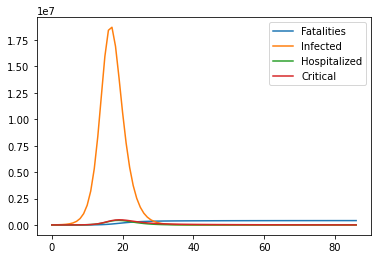

In [11]:
model = SEICHAR(region=region, seed=seed)
model.run()
print(model)
SEICHARPlot(model).plot()

In [12]:
a = 10

## Necessidade de leitos

Projeção da quantidade de leitos necessários, ocupados e disponíveis na região

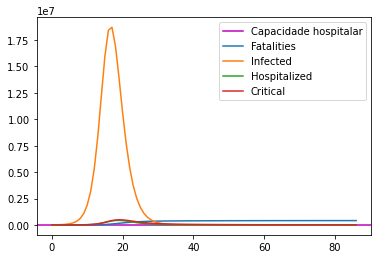

In [15]:
fig, ax = plt.subplots()
ax.axhline(y=model.hospital_total_capacity, color='m', label="Capacidade hospitalar")
SEICHARPlot(model).plot()

Conforme o gráfico acima, o sistema de saúde atinge sua lotação máxima em **{{model.hospital_limit_time}}** dias. Ou seja, a partir do dia {{model.hospital_limit_date}}, todos os leitos dos hospitais estarão sendo usados (considerando apenas os pacientes com covid-19)

In [16]:
# Por mil habitantes
pormil = False # Falso para valores absolutos

nec [430292.30930626317, 88582.88311442593]
disp [149.641536, 68018.87999999999]
ocup [317.9882640000001, 144540.12]
total [467.62980000000005, 212559.0]


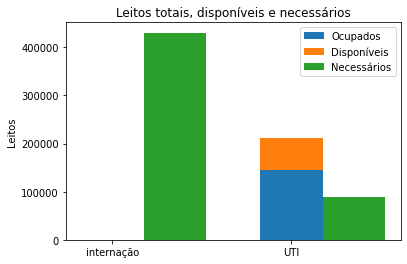

In [17]:
labels = ['internação', 'UTI']

available = [model.hospital_capacity, model.icu_capacity]
capacity = [model.hospital_total_capacity, model.icu_total_capacity]
required = [model.peak_hospitalization_demand, model.peak_icu_demand]
unavailable = [total-av for total, av in zip(capacity, available)]

label = ""
if pormil:
    pop = model.population
    label = "por mil habitantes"
    available = [item/pop * 1000 for item in available]
    capacity = [item/pop * 1000 for item in capacity]
    unavailable = [item/pop * 1000 for item in unavailable]
    required = [item/pop * 1000 for item in required]

print("nec", required)
print("disp", available)
print("ocup", unavailable)
print("total", capacity)

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()

ax.bar(labels, unavailable, width, label='Ocupados')
ax.bar(labels, available, width, bottom=unavailable, label='Disponíveis')
ax.bar(width+x, required, width, label='Necessários')

ax.set_ylabel('Leitos'+label)
ax.set_title('Leitos totais, disponíveis e necessários')
ax.legend()

plt.show()

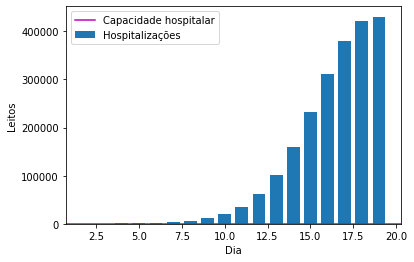

In [18]:
peak = model.peak_hospitalization_demand
h = model['hospitalized']
day_collapsed = model.hospital_limit_time
days_to_peak = int(h.index[h == peak].to_list()[0])
h = h[day_collapsed:days_to_peak]

width = 0.75
fig, ax = plt.subplots()

ax.axhline(y=model.hospital_capacity, color='m', label="Capacidade hospitalar")
ax.bar(h.index, h, width, label="Hospitalizações")

ax.set_ylabel('Leitos')
ax.set_xlabel('Dia')
plt.legend()
plt.show()